# ProbAI ChiRho Tutorial II: Backdoor Adjustment

## Outline

- [Setup](#setup)

- [Overview: Systematically adjusting for observed confounding](#overview:-systematically-adjusting-for-observed-confounding)
    - [Task: Treatment effect estimation with observational data](#task:-treatment-effect-estimation-with-observational-data)
    - [Challenge: Confounding](#challenge:-confounding)
    - [Assumptions: All confounders observed](#assumptions:-all-confounders-observed)
    - [Intuition: Statistically adjusting for confounding](#intuition:-statistically-adjusting-for-confounding)

- [Example: Evaluating the impact of a job training program](#example:-evaluating-the-impact-of-a-job-training-program)
    - [Variables](#variables)
    - [Motivation](#motivation)
    - [Source](#source)

- [Causal Probabilistic Program](#causal-probabilistic-program)
    - [Model Description](#model-description)
    - [Prior Description](#prior-description)
    - [Informal Prior Predictive Check: Visualizing Samples](#informal-prior-predictive-check---visualizing-samples)

- [Causal Query: average treatment effect (ATE)](#causal-query:-average-treatment-effect-\(ATE\))

- [Causal Inference as Probabilistic Inference](#causal-inference-as-probabilistic-inference)

- [Results](#results)


## Setup

Here, we install the necessary Pytorch, Pyro, and ChiRho dependencies for this example.

In [10]:
%reload_ext autoreload
%autoreload 2
%pdb off

from typing import Dict, List, Optional, Tuple, Union, TypeVar

import os
import torch
import pyro
import pyro.distributions as dist
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pytorch_lightning as pl

from pyro.nn import PyroModule, PyroSample
from pyro.poutine import replay, trace
from pyro.ops.indexing import Vindex

from pyro.infer.autoguide import AutoDelta,  AutoNormal
from pyro.infer import SVI, Predictive

from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.indexed.ops import IndexSet, gather
from chirho.interventional.handlers import do
from chirho.observational.handlers import condition

pyro.clear_param_store()
pyro.set_rng_seed(1234)
pyro.settings.set(module_local_params=True)

smoke_test = ('CI' in os.environ)
max_epochs = 10 if smoke_test else 1000
num_samples = 10 if smoke_test else 10000

Automatic pdb calling has been turned OFF


## Overview: Systematically adjusting for observed confounding


### **Task:** Treatment effect estimation with observational data
In this example, we are interested in estimating how changes (or interventions) to a particular treatment variable $T$ influence a particular outcome variable $Y$. We wish to estimate this causal effect using *observational* (non-randomized) data from $T$, $Y$, and some collection of covariates $X = \{X_1, ..., X_d\}$. 

In this example we'll assume that $T$ is a binary random variable, but the concepts carry over exactly when $T$ is continuous or discrete-ordinal.

### **Challenge:** Confounding

Unfortunately, naively estimating the effect of an intervention by simply approximating $P(Y|T)$ alone may produce poor estimates of $T$'s effect on $Y$. In these kinds of *observational* settings, some collection of variables $Z = \{Z_1, ..., Z_{d'}\}$ may influence both $T$ and $Y$, resulting in a statistical dependence that is not reflective of the causal effect we are interested in estimating. These variables are called "confounders", and pose a serious problem for drawing causal conclusions from observational data.

### **Assumptions:** All confounders observed

In this example we assume that all confounders between $T$ and $Y$ are observed. In other words, $Z \subseteq X$.

For technical reasons that are out of scope of this tutorial \[Cinelli et. al., 2020\], we also assume that no elements of $X$ are common effects of $T$ and $Y$, nor are they influenced by any sets of variables $U_1$, $U_2$ such that $U_1$ influences $T$ and $U_2$ influences $Y$. This somewhat more technical assumption avoids the possibility of "collider bias", also sometimes refered to as "Berkson's paradox". See https://en.wikipedia.org/wiki/Berkson%27s_paradox for more discussion of Berkson's paradox.

### **Intuition:** Statistically adjusting for confounding



If all of the confounders are observed, then we can imagine partitioning our data instances into subsets of instances that have similar values of $X$ and then estimating the statistical dependence between $T$ and $Y$ within each subset of instances. Because we've assumed that $X$ contains all possible confounders, then any remaining statistical dependence must be attributable to $T$'s influence on $Y$. To yield a population-averaged effect estimate, we simply take a weighted average of these subgroup effect estimates where the weights are given by the (estimated) marginal probability of $X$.

Importantly, this "matching" description provides an intuition about how the assumptions result in unbiased statistical inferences of the effect of $T$ on $Y$. In practice, it is often very hard to partition data into explicit subsets of similar units, especially if $X$ is high dimensional. ChiRho's approach, in which counterfactual outcomes are imputed using a Bayesian model, also produces unbiased estimates, albeit in a less immediately intuitive way.

## Example: Evaluating the impact of a job training program

### Variables

As a working example, consider the scenario where $T$ represents whether an individual did ($T=1$) or didn't ($T=0$) participate in a job training program, and $Y$ represents their earnings 2 years later. In addition to these measurements, we also gather a collection of covariates $X$ describing each individual's attributes, including academic background, previous earnings, etc. 

### Motivation

Understanding the effect of the job training program on earnings 2 years later may be useful for policymakers who may wish to provide more funding for programs in the future. Providing new funding acts like a kind of intervention, as it changes the mechanism by which individuals choose whether to participate in a job training program. See our [Introductory Tutorial](tutorial_i.ipynb) for a more in-depth discussion of the difference between association and intervention.

### Source

This scenario (and the data we'll use later) come from a real study by Robert Lalonde on the efficacy of training programs, and has become a de facto example for causal inference with observational data \[LaLonde, 1986\].

In [90]:
# Load the data
DATA_URL = "https://raw.githubusercontent.com/rugg2/rugg2.github.io/master/lalonde.csv"
data = pd.read_csv(DATA_URL)

# Convert the data to the right format
data["re75"] = data["re75"] / 1000
# Add a small constant to avoid log(0) in the model
data["re78"] = data["re78"] / 1000 + 1e-6
data = data.rename(columns={"educ": "education", "hispan": "hispanic"})

# Define the covariates
covariates_names = ["education", "age", "re75", "black", "hispanic", "married", "nodegree"]

# Extract treatment, covariates and earnings from the dataframe
df = data[["treat", *covariates_names, "re78"]]

# Convert to tensors
covariates_obs = torch.tensor(df[covariates_names].values).float()
training_obs = torch.tensor(df["treat"].values).float()
earnings_obs = torch.tensor(df["re78"].values).float()

df[df['re75']>0]

,treat,education,age,re75,black,hispanic,married,nodegree,re78
111,1,9,17,0.074343,0,1,0,1,6.210671
112,1,12,20,0.165208,1,0,0,0,0.000001
113,1,11,18,0.214564,1,0,0,1,0.929885
114,1,12,27,0.334049,1,0,1,0,0.000001
115,1,12,21,0.334049,0,0,0,0,12.558021
...,...,...,...,...,...,...,...,...,...
475,0,6,16,0.044758,1,0,0,1,0.000001
476,0,8,22,0.042968,0,0,1,1,0.209838
477,0,12,31,0.042968,1,0,1,0,11.023841
478,0,11,20,0.039387,0,0,1,1,6.280339


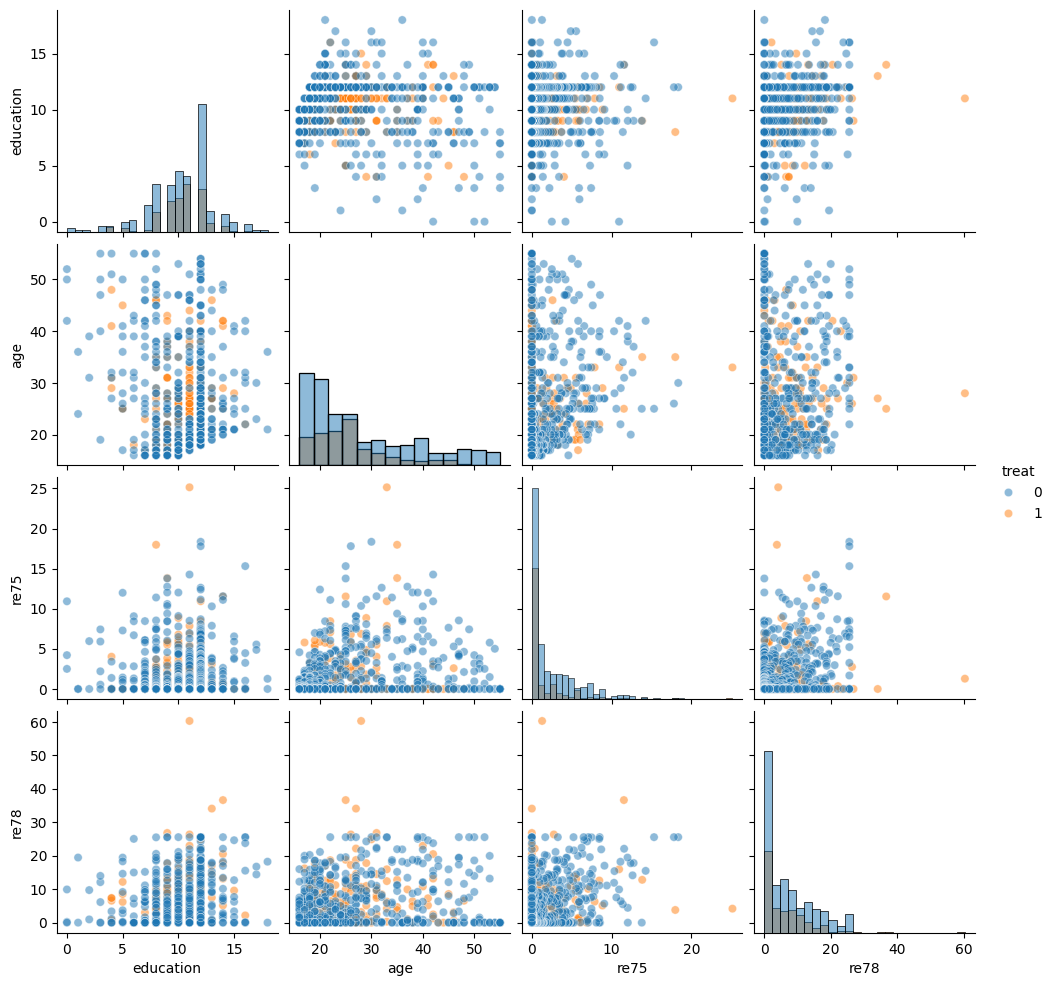

In [84]:
# Visualize the data
sns.pairplot(df[["treat", "education", "age", "re75", "re78"]], hue="treat", diag_kind="hist", plot_kws=dict(alpha=0.5))

In [102]:
# Evaluate what our answer would be if we just naively predicted the average earnings of treated and untreated individuals, 
# without accounting for the potential confounders.
treated_individuals = df[df["treat"] == 1]
untreated_individuals = df[df["treat"] == 0]

naive_prediction = (treated_individuals["re78"].mean() - untreated_individuals["re78"].mean()) 
naive_prediction * 1000

np.float64(-635.0262120374222)

Surprisingly, the average earning of treated individuals (i.e. individuals who have received job training) is lower than untreated.
Without accounting for confounders, it may seem that job training makes people earn less!

## Causal Probabilistic Program

Our causal assumptions can be encoded as a probabilistic program in Pyro. Here, unlike in the [Tutorial](tutorial_i.ipynb), we'll write a probabilistic program in a single pass that includes the causal relationships between attributes and the priors over parameters.

We'll also introduce `PyroModule`s as a way to build probabilistic models. In the first tutorial, we wrote models as stochastic functions (i.e. functions that call `pyro.sample`) that took distribution parameters as arguments. When we wanted to introduce a prior for our smoking model, we added a second function for sampling those parameters. `PyroModule`s give us more tools for structuring our models and they make it easier to introduce priors.

To demonstrate, lets revisit the model we built in the tutorial and convert it to a `PyroModule`.

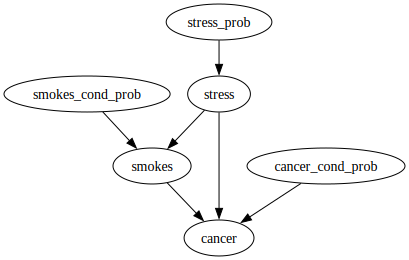

In [11]:
def causal_model(stress_prob, smokes_cond_prob, cancer_cond_prob):
    stress = pyro.sample("stress", dist.Bernoulli(stress_prob))

    smokes_prob = Vindex(smokes_cond_prob)[..., stress.int()]
    smokes = pyro.sample("smokes", dist.Bernoulli(smokes_prob))

    cancer_prob = Vindex(cancer_cond_prob)[..., stress.int(), smokes.int()]
    cancer = pyro.sample("cancer", dist.Bernoulli(cancer_prob))

    return {"stress": stress, "smokes": smokes, "cancer": cancer}

def parameter_prior():
    stress_prob = pyro.sample("stress_prob", dist.Beta(1.0, 1.0))
    smokes_cond_prob = pyro.sample(
        "smokes_cond_prob", dist.Beta(torch.ones(2), torch.ones(2)).to_event(1)
    )
    cancer_cond_prob = pyro.sample(
        "cancer_cond_prob", dist.Beta(torch.ones(2, 2), torch.ones(2, 2)).to_event(2)
    )
    return stress_prob, smokes_cond_prob, cancer_cond_prob

class SmokingModel(PyroModule):
    @PyroSample
    def stress_prob(self):
        return dist.Beta(1.0, 1.0)

    @PyroSample
    def smokes_cond_prob(self):
        return dist.Beta(torch.ones(2), torch.ones(2)).to_event(1)

    @PyroSample
    def cancer_cond_prob(self):
        return dist.Beta(torch.ones(2, 2), torch.ones(2, 2)).to_event(2)

    def forward(self):
        stress = pyro.sample("stress", dist.Bernoulli(self.stress_prob))

        smokes_prob = Vindex(self.smokes_cond_prob)[..., stress.int()]
        smokes = pyro.sample("smokes", dist.Bernoulli(smokes_prob))
    
        cancer_prob = Vindex(self.cancer_cond_prob)[..., stress.int(), smokes.int()]
        cancer = pyro.sample("cancer", dist.Bernoulli(cancer_prob))
    
        return {"stress": stress, "smokes": smokes, "cancer": cancer}

pyro.render_model(SmokingModel())

### Model Description

As our assumptions are relatively straightforward, they can be codified entirely in the ordering of random variables in our causal probabilistic program. Specifically, we have written our `causal_model` method below such that `covariates` influence `training` and `earnings`, and `training` influences `earnings`. To align this model with the specific parametric assumptions used in our case study \[LaLonde, 1986\], we have chosen to use a logistic function to describe the mechanism for generating `training` random variables, and a linear Gaussian model for generating `earnings`.

### Prior Description

In order to represent our uncertainty over causal models, we place `Normal`, `HalfCauchy`, and `LKJCholesky` priors on each of the 8 parameters used in our `causal_model`. For each, we choose the prior based on the desired support of the parameter. E.g. variances are strictly positive, therefore we choose a `HalfCauchy` distribution.

In [ ]:
class BayesianBackdoor(PyroModule):
    zero: torch.Tensor
    one: torch.Tensor
    
    def __init__(self, d_covariates=7):
        super().__init__()
        self.d_covariates = d_covariates
        self.register_buffer("zero", torch.tensor(0.))
        self.register_buffer("one", torch.tensor(1.))
        self.register_buffer("loc_covariates_loc", torch.tensor([10., 35., 15.] + [1.] * (self.d_covariates - 3)))

    @PyroSample
    def loc_covariates(self):
        return dist.Normal(self.loc_covariates_loc, self.one).to_event(1)

    @PyroSample
    def variances_covariates(self):
        return dist.HalfCauchy(self.one).expand([self.d_covariates]).to_event(1)
        
    @PyroSample
    def lower_cholesky_covariates(self):
        return dist.LKJCholesky(self.d_covariates, self.one)

    @PyroSample
    def weights_training(self):
        return dist.Normal(self.zero, 1. / self.loc_covariates_loc[..., None]).expand([self.d_covariates, 1]).to_event(2)

    @PyroSample
    def bias_training(self):
        return dist.Normal(self.zero, self.one * 10.).expand([1]).to_event(1)

    @PyroSample
    def weights_earnings(self):
        return dist.Normal(self.zero, 1. / self.loc_covariates_loc[..., None]).expand([self.d_covariates, 2]).to_event(2)
    
    @PyroSample
    def bias_earnings(self):
        return dist.Normal(self.zero, self.one * 10.).expand([2]).to_event(1)
    
    @PyroSample
    def variance_earnings(self):
        return dist.HalfCauchy(self.one * 10.).expand([2]).to_event(1)

    def forward(self):
        # Sample covariates from a multivariate normal distribution     
        scale_tril = torch.diag_embed(self.variances_covariates.sqrt()) @ self.lower_cholesky_covariates
        covariates = pyro.sample("covariates", dist.MultivariateNormal(self.loc_covariates, scale_tril=scale_tril))
        
        # Sample training (treatment) from a logistic function of the covariates
        logit_training = torch.einsum("...a,...ab->...b", covariates, self.weights_training) + self.bias_training
        training = (pyro.sample("training", dist.Bernoulli(torch.special.expit(logit_training[..., 0])))).long()

        # Sample earnings (outcome) from a linear Gaussian function of the covariates and the treatment
        loc_earnings = torch.einsum("...a,...ab->...b", covariates, self.weights_earnings) + self.bias_earnings
        loc_earnings = torch.where(training == 1, loc_earnings[..., 1], loc_earnings[..., 0])
        variance_earnings = torch.where(training == 1, self.variance_earnings[..., 1], self.variance_earnings[..., 0])
        earnings = pyro.sample("earnings", dist.FoldedDistribution(dist.Normal(loc_earnings, variance_earnings)))
        
        return covariates, training, earnings

### Problem 1:

Fill in `ConditionedBayesianBackdoor` so that it conditions the `BayesianBackdoor` model on our observed data.

Hint 1: `BayesianBackdoor` returns a single sample from the model, but we have many independent observations. 
You will need a call to `pyro.plate`.

Hint 2: The model parameters should be shared across observations. There is [some subtlety](https://pyro.ai/examples/modules.html#%E2%9A%A0-Caution:-accessing-attributes-inside-plates) in how model parameters interact with plates.

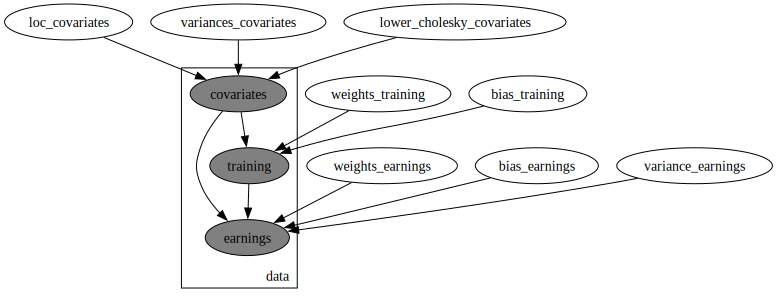

In [94]:
class ConditionedBayesianBackdoor(BayesianBackdoor):
    def forward(self, covariates_obs=None, training_obs=None, earnings_obs=None):
        #+begin_solution
        n = covariates_obs.shape[0]
        self.loc_covariates
        self.variances_covariates
        self.lower_cholesky_covariates
        self.weights_training
        self.bias_training
        self.weights_earnings
        self.bias_earnings
        self.variance_earnings

        with pyro.plate("data", n, dim=-1):
            with condition(data={"covariates": covariates_obs, "training": training_obs, "earnings": earnings_obs}):
                return super().forward()
        #+end_solution

bayesian_backdoor = ConditionedBayesianBackdoor()
pyro.render_model(bayesian_backdoor, model_args=(covariates_obs, training_obs, earnings_obs))

### Informal Prior Predictive Check - Visualizing Samples

As this model involved several priors over multiple parameters, it is helpful to probe some implications of these modeling decisions on the induced distribution over individual attributes. As we always expect to be conditioning on covariates in our analyses, we only focus on sampling from the prior distribution on `training` and `earnings` random variables conditional on the observed `covariates_obs`.

In [82]:
def plot_predictive(model, covariates_obs, training_obs, earnings_obs, guide=None, compare_source=True):
    if guide:
        guide_tr = trace(guide).get_trace(covariates_obs, training_obs, earnings_obs)
        model_tr = trace(replay(model, trace=guide_tr)).get_trace(covariates_obs, training_obs, earnings_obs)
    else:
        model_tr = trace(model).get_trace(covariates_obs, training_obs, earnings_obs)

    covariates = model_tr.nodes['covariates']['value']
    training = model_tr.nodes['training']['value'][:, None]
    earnings = model_tr.nodes['earnings']['value'][..., :, None]

    samples = torch.concat((training, covariates, earnings), dim=1).detach().numpy()

    predictive_df = pd.DataFrame(samples, columns=["treat", *covariates_names, "re78"]).astype({"treat":"int8"})

    data_copy = df.copy()
    data_copy["source"] = "data"

    predictive_copy = predictive_df.copy()
    predictive_copy["source"] = "predictive"

    if compare_source:
        # Note that `.sample(frac=1).reset_index(drop=True)` shuffles the rows to minimize overplotting problems
        sns.pairplot(pd.concat((data_copy, predictive_copy), ignore_index=True)[["treat", "education", "age", "re75", "re78", "source"]].sample(frac=1).reset_index(drop=True), hue="source", diag_kind="hist", plot_kws=dict(alpha=0.5))
    else:
        sns.pairplot(predictive_df[["treat", "education", "age", "re75", "re78"]], hue="treat", diag_kind="hist")

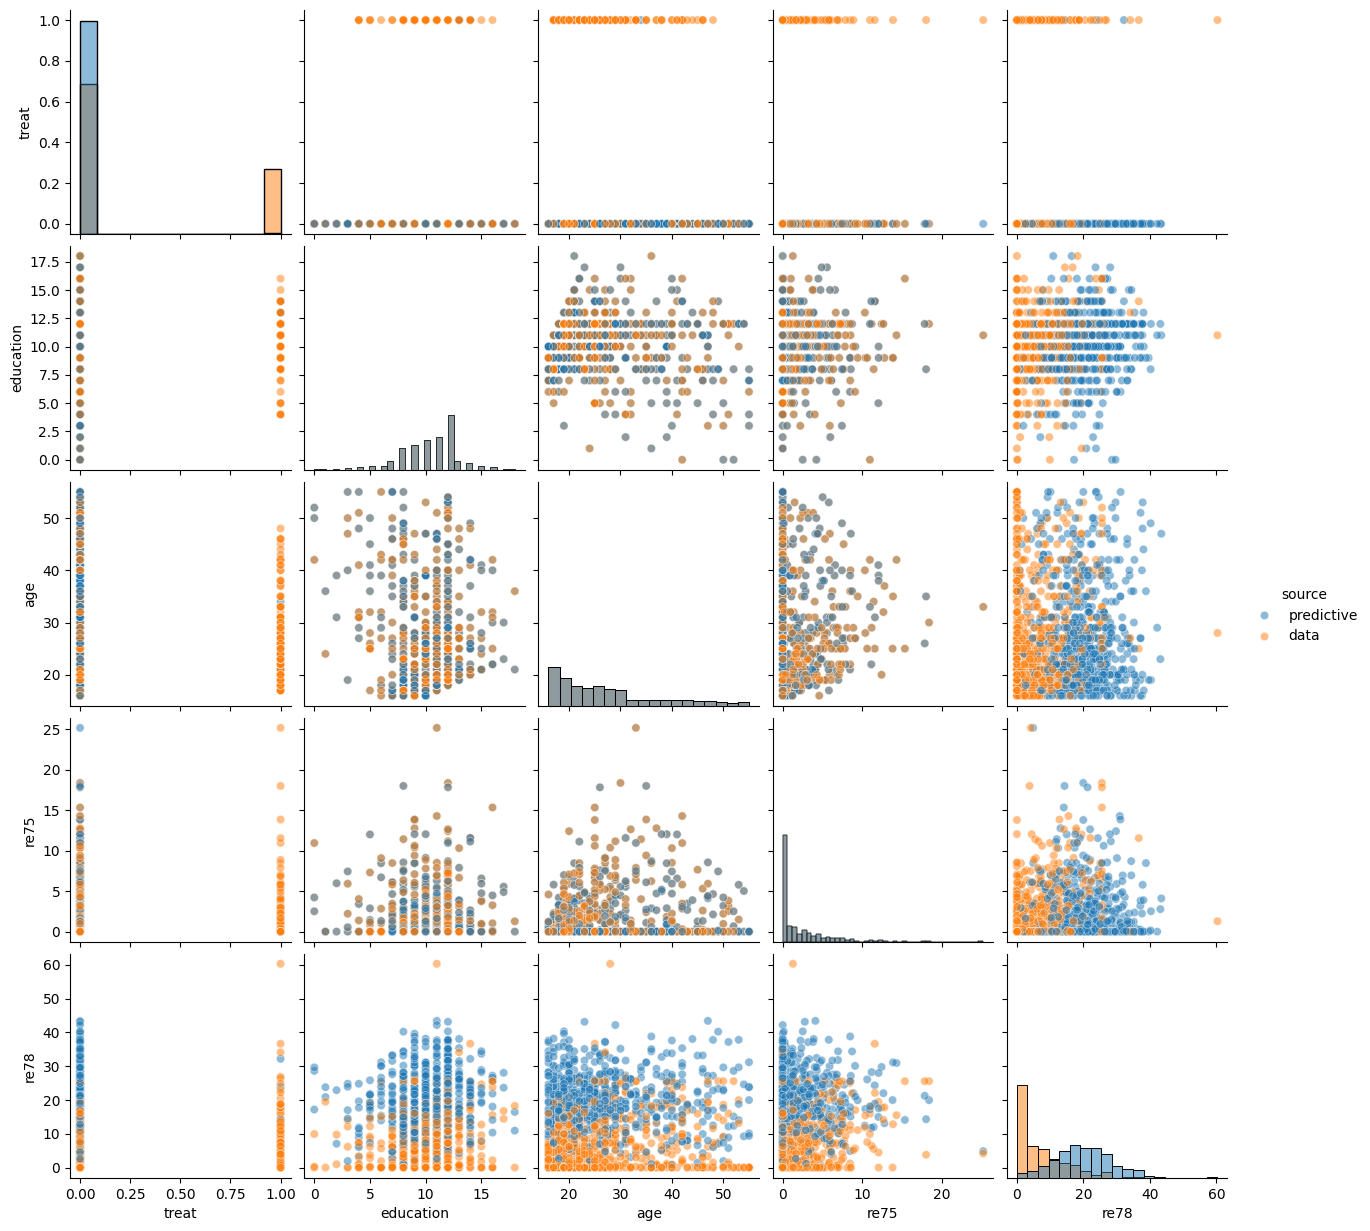

In [83]:
plot_predictive(bayesian_backdoor, covariates_obs, None, None)

## Causal Query: average treatment effect (ATE)

In this setting we wish to compute the *average treatment effect*, $ATE = \mathbb{E}[Y|do(T=1)] - \mathbb{E}[Y|do(T=0)]$. The `do` notation indicates that the expectations are taken according to *intervened* versions of the model, with $T$ set to a particular value. Note from our [tutorial](tutorial_i.ipynb) that this is different from conditioning on $T$ in the original `causal_model`, which assumes $X$ and $T$ are dependent.

In words, in this setting the ATE tells us how much greater the salaries across all individuals if we forced everyone to participate in the job training program relative to if we forced everyone to not participate in the job training program. Here, we are interested in the average over the entire population. Other estimands, such as the conditional average treatment effect, may be interested in the average effect for individuals with particular attributes of interest.

To implement this query in ChiRho we extend our `BayesianBackdoor` model by applying two interventions, `do(actions={"training":0})` and `do(actions={"training":1})`, and then sampling jointly from counterfactual worlds using the `MultiWorldCounterfactual` handler. Recall from the [tutorial](tutorial_i.ipynb) that the `MultiWorldCounterfactual` handler modifies the execution of the causal model to sample jointly from the observational and all counterfactual worlds induced by an intervention.

### Problem 2:

Complete the implementation of the sample average treatment effect. 

Hint: You may find the documentation of [do](https://basisresearch.github.io/chirho/interventional.html#chirho.interventional.handlers.do), [MultiWorldCounterfactual](https://basisresearch.github.io/chirho/counterfactual.html#chirho.counterfactual.handlers.counterfactual.MultiWorldCounterfactual), and [gather](https://basisresearch.github.io/chirho/counterfactual.html#chirho.counterfactual.handlers.counterfactual.MultiWorldCounterfactual) helpful.

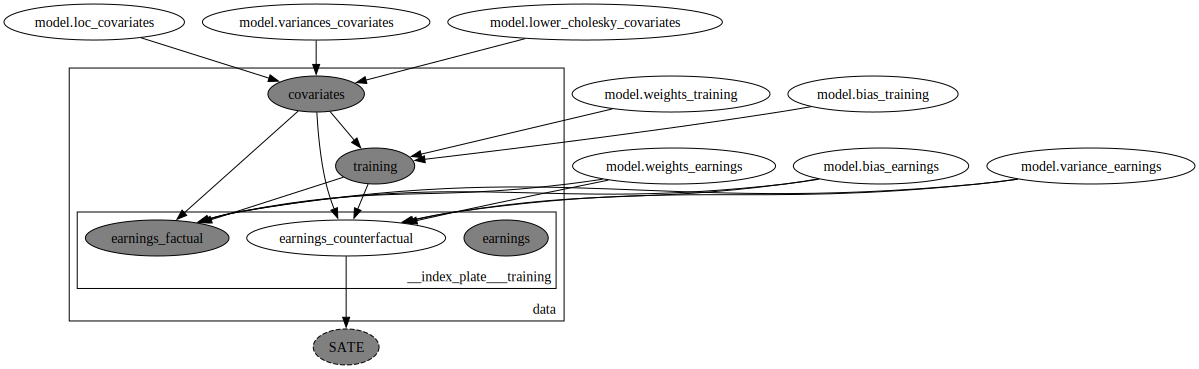

In [121]:
class BayesianBackdoorSATE(PyroModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        
    def forward(self, covariates_obs, training_obs, earnings_obs):
        #+begin_solution
        # Sample jointly from observational and counterfactual distributions
        with MultiWorldCounterfactual(), do(actions={"training": (0., 1.)}):
            _, _, earnings = self.model.forward(covariates_obs, training_obs, earnings_obs)

            # Evaluate the sample average treatment effect
            earnings_0 = gather(earnings, IndexSet(training={1})) # no training
            earnings_1 = gather(earnings, IndexSet(training={2})) # with training
            ites = earnings_1 - earnings_0
            sate = torch.mean(ites, dim=-1, keepdim=True)
        #+end_solution
        return pyro.deterministic("SATE", sate, event_dim=0)

#+begin_solution
class BayesianBackdoorSATE(PyroModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        
    def forward(self, covariates_obs, training_obs, earnings_obs):
        # Sample jointly from observational and counterfactual distributions
        with MultiWorldCounterfactual(), do(actions={"training": 1. - training_obs}):
            _, _, earnings = self.model.forward(covariates_obs, training_obs, earnings_obs)
        
            # Evaluate the sample average treatment effect
            earnings_cf = gather(earnings, IndexSet(training={1}))
            earnings_f = gather(earnings, IndexSet(training={0}))
            earnings_1 = torch.where(training_obs == 1, earnings_f, earnings_cf)
            earnings_0 = torch.where(training_obs == 0, earnings_f, earnings_cf)
            ites = earnings_1 - earnings_0
            return pyro.deterministic("SATE", torch.mean(ites, dim=-1, keepdim=True), event_dim=0)
#+begin_solution

bayesian_backdoor_sate = BayesianBackdoorSATE(ConditionedBayesianBackdoor())
pyro.render_model(bayesian_backdoor_sate, model_args=(covariates_obs, training_obs, earnings_obs))

## Causal Inference as Probabilistic Inference

In this section we show the use of Pyro's automated stochastic variational inference tools to solve our causal inference problem. Specifically, we fit an `AutoLowRankMultivariateNormal` approximation to the joint posterior distribution on model parameters given observed data. We will then use this approximate posterior to impute the counterfactual earnings for each individual and compute our estimate of the ATE.

In [122]:
class LightningSVI(pl.LightningModule):
    def __init__(self, elbo: pyro.infer.elbo.ELBOModule, **optim_params):
        super().__init__()
        self.optim_params = dict(optim_params)
        self.elbo = elbo

    def configure_optimizers(self):
        return torch.optim.Adam(self.elbo.parameters(), **self.optim_params)

    def training_step(self, batch, batch_idx):
        return self.elbo(*batch)


# Fit a guide to the posterior distribution for the observed data only
model = bayesian_backdoor_sate.model

guide = pyro.infer.autoguide.AutoLowRankMultivariateNormal(model)
elbo = pyro.infer.Trace_ELBO(num_particles=100, vectorize_particles=True)
elbo = elbo(model, guide)

# initialize parameters
elbo(covariates_obs, training_obs, earnings_obs)

# fit parameters
batch_size = covariates_obs.shape[0]
train_dataset = torch.utils.data.TensorDataset(covariates_obs, training_obs, earnings_obs)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
svi = LightningSVI(elbo, lr=0.1)
trainer = pl.Trainer(max_epochs=max_epochs, log_every_n_steps=1, accelerator="cpu")
trainer.fit(svi, train_dataloaders=train_dataloader)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/feser/work/basis/chirho/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | elbo | ELBOModule | 610    | train
--------------------------------------------
610       Trainable params
0         Non-trainable params
610       Total params
0.002     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/feser/work/basis/chirho/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers 

Training: |                                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


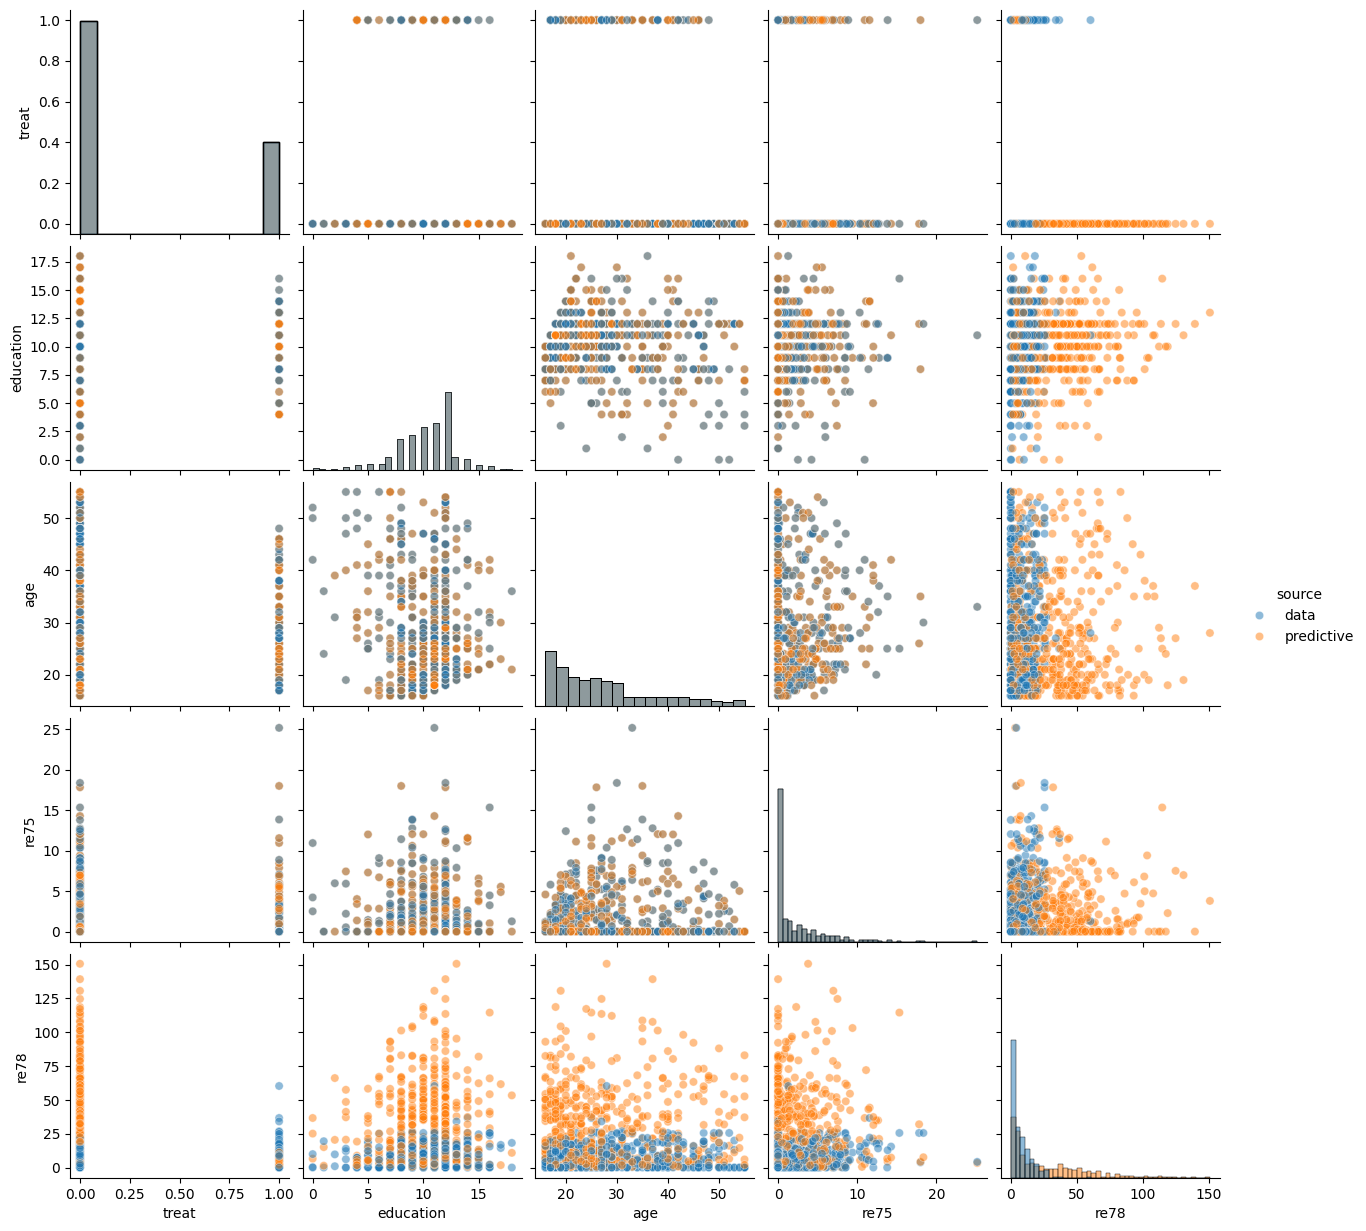

In [123]:
# Visualize posterior predictive sample
plot_predictive(bayesian_backdoor, covariates_obs, training_obs, None, guide=guide)

## Results

Here, we compare the results of our probabilistic programming approach compared with a standard implementation of linear regression for causal inference (described in [this blog post](https://rugg2.github.io/Lalonde%20dataset%20-%20Causal%20Inference.html)).

In [124]:
# https://rugg2.github.io/Lalonde%20dataset%20-%20Causal%20Inference.html
blog_prediction_ols = 1548.24 / 1000 # Scaled by 1000 to be consistent with data preprocessing above.
blog_prediction_matching = 1027.087 / 1000
blog_prediction_matching_ci95 = [-705.131 / 1000, 2759.305 / 1000]

predictive = pyro.infer.Predictive(bayesian_backdoor_sate, guide=guide, num_samples=num_samples, parallel=False)
mf_prediction = predictive(covariates_obs, training_obs, earnings_obs)["SATE"]

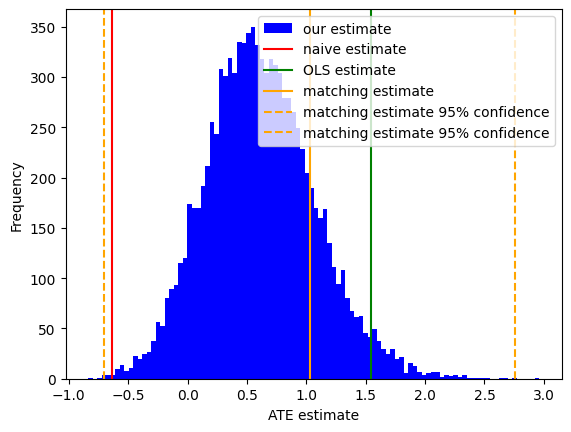

In [125]:
fig, ax = plt.subplots(1, 1)
ax.hist(mf_prediction.squeeze(), bins=100, color="blue", label="our estimate")
ax.axvline(naive_prediction, color="red", label="naive estimate")
ax.axvline(blog_prediction_ols, 0, 50, color="green", label="OLS estimate")
ax.axvline(blog_prediction_matching, 0, 50, color="orange", label="matching estimate")
for x in blog_prediction_matching_ci95:
    ax.axvline(x, color="orange", linestyle="dashed", label="matching estimate 95% confidence")
ax.set(xlabel="ATE estimate", ylabel="Frequency")
ax.legend()

Here, we can clearly see that our approximate inference more closely agrees with prior results using a simple linear regression and sample matching than with the naive estimate that simply ignores covariates altogether:
where the naive estimate finds a negative effect (i.e. participating in the training program reduced earnings on average!),
the estimates that control for covariates find a positive effect.

Unfortunately for the job training program being studied, the more optimistic linear regression estimator does a poor job at controlling for covariates,
and as a result it is overconfident in its predictions on what is ultimately a very small and noisy dataset.
To illustrate this, we also include the 95% confidence interval for the matching estimate.
While this frequentist confidence interval is not directly comparable to our Bayesian posterior distribution,
both uncertainty estimates suggest that the effect is likely smaller and less statistically significant than was originally believed.

### Problem 3:

If you computed the SATE by performing two interventions and computing the difference, there is a better estimator available.
Try to find a solution that performs a single intervention and also makes use of the factual data. You should see a reduction in the variance on the previous plot.

### Problem 4:

The posterior predictive plot shows that the model we built is not a perfect fit for the data.
Try to find a variant that fits the data better, and see if that changes the ATE estimate.

## References

<!-- Apparently sphinx can't handle references inside .ipynb's, so doing this manually for now. -->
Cinelli, Carlos, Andrew Forney, and Judea Pearl. “A Crash Course in Good and Bad Controls.” SSRN Electronic Journal, 2020. https://doi.org/10.2139/ssrn.3689437.

LaLonde, Robert J. “Evaluating the Econometric Evaluations of Training Programs with Experimental Data.” The American Economic Review 76, no. 4 (1986): 604–20.
